In [64]:
%matplotlib inline
import json
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [2]:
with sqlite3.connect('obs_rainfall.sqlite') as conn:
    df = pd.read_sql_query('SELECT * FROM rainobs', conn)

In [3]:
col = [
    'stationName', 
    'obsTime', 
    'rain1hr', 
    'rain10min', 
    'rain3hr', 
    'rain6hr', 
    'rain12hr', 
    'rain24hr', 
    'rainToday', 
    'fromLast1dayToNow', 
    'fromLast2dayToNow'
]
df = df[col]
df.head()

,stationName,obsTime,rain1hr,rain10min,rain3hr,rain6hr,rain12hr,rain24hr,rainToday,fromLast1dayToNow,fromLast2dayToNow
0,九份二山,2019-08-29T18:50:00+08:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
1,基隆,2019-08-29T18:50:00+08:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
2,淡水,2019-08-29T18:50:00+08:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
3,板橋,2019-08-29T18:50:00+08:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
4,陽明山,2019-08-29T18:50:00+08:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00


In [4]:
df['obsTime'] = pd.to_datetime(df['obsTime']).dt.tz_localize(None)
df.head()

,stationName,obsTime,rain1hr,rain10min,rain3hr,rain6hr,rain12hr,rain24hr,rainToday,fromLast1dayToNow,fromLast2dayToNow
0,九份二山,2019-08-29 18:50:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
1,基隆,2019-08-29 18:50:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
2,淡水,2019-08-29 18:50:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
3,板橋,2019-08-29 18:50:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00
4,陽明山,2019-08-29 18:50:00,-998.00,-998.00,-998.00,-998.00,0.00,0.00,0.00,0.00,0.00


In [5]:
df6 = df[['stationName', 'obsTime', 'rain6hr']].copy()
df6['rain6hr'] = df6['rain6hr'].astype(float)
df6.head()

,stationName,obsTime,rain6hr
0,九份二山,2019-08-29 18:50:00,-998.0
1,基隆,2019-08-29 18:50:00,-998.0
2,淡水,2019-08-29 18:50:00,-998.0
3,板橋,2019-08-29 18:50:00,-998.0
4,陽明山,2019-08-29 18:50:00,-998.0


In [6]:
df6.loc[df6.rain6hr <= 0, 'rain6hr'] = 0
df6.head()

,stationName,obsTime,rain6hr
0,九份二山,2019-08-29 18:50:00,0.0
1,基隆,2019-08-29 18:50:00,0.0
2,淡水,2019-08-29 18:50:00,0.0
3,板橋,2019-08-29 18:50:00,0.0
4,陽明山,2019-08-29 18:50:00,0.0


In [7]:
minute_cond = df6.obsTime.dt.minute == 0
hour_cond = (df6.obsTime.dt.hour == 0) | (df6.obsTime.dt.hour == 6) | (df6.obsTime.dt.hour == 12) | (df6.obsTime.dt.hour == 18)
df6 = df6[minute_cond & hour_cond]
df6.head()

,stationName,obsTime,rain6hr
5620,九份二山,2019-08-30,0.0
5621,基隆,2019-08-30,0.0
5622,淡水,2019-08-30,0.0
5623,板橋,2019-08-30,0.0
5624,陽明山,2019-08-30,0.0


In [8]:
station2county = json.load(open('station_info.json'))
df6['county'] = df6['stationName'].map(station2county)
df6 = df6[~df6['county'].isna()]
df6.head(10)

,stationName,obsTime,rain6hr,county
5620,九份二山,2019-08-30,0.0,南投縣
5621,基隆,2019-08-30,0.0,基隆市
5622,淡水,2019-08-30,0.0,新北市
5623,板橋,2019-08-30,0.0,新北市
5624,陽明山,2019-08-30,0.0,臺北市
5625,鞍部,2019-08-30,0.0,臺北市
5626,新竹,2019-08-30,0.0,新竹縣
5627,臺中,2019-08-30,0.0,臺中市
5628,梧棲,2019-08-30,0.0,臺中市
5629,澎湖,2019-08-30,0.0,澎湖縣


In [59]:
with sqlite3.connect('county_36hr_forecast.sqlite') as conn:
    df_f = pd.read_sql_query('SELECT * FROM county', conn)

rain_f = df_f.loc[df_f['element'] == 'PoP', ['location', 'issueTime', 'startTime', 'endTime', 'value']]

# dealing with time zone
for time_type in ['issueTime', 'startTime', 'endTime']:
    rain_f[time_type] = pd.to_datetime(rain_f[time_type]).dt.tz_localize(None)
    
rain_f['lead_time'] = rain_f['startTime'] - rain_f['issueTime']
rain_f.head()

,location,issueTime,startTime,endTime,value,lead_time
12,臺北市,2019-08-28 11:00:00,2019-08-28 12:00:00,2019-08-28 18:00:00,0,01:00:00
13,臺北市,2019-08-28 11:00:00,2019-08-28 18:00:00,2019-08-29 06:00:00,0,07:00:00
14,臺北市,2019-08-28 11:00:00,2019-08-29 06:00:00,2019-08-29 18:00:00,30,19:00:00
27,新北市,2019-08-28 11:00:00,2019-08-28 12:00:00,2019-08-28 18:00:00,0,01:00:00
28,新北市,2019-08-28 11:00:00,2019-08-28 18:00:00,2019-08-29 06:00:00,0,07:00:00


In [60]:
leadtime_idx = rain_f['lead_time'] == '01:00:00'
rain_f_l1 = rain_f.loc[leadtime_idx, ['location', 'startTime', 'value']]
rain_f_l1['value'] = rain_f_l1['value'].astype(int)
rain_f_l1.head()

,location,startTime,value
12,臺北市,2019-08-28 12:00:00,0
27,新北市,2019-08-28 12:00:00,0
42,桃園市,2019-08-28 12:00:00,0
57,臺中市,2019-08-28 12:00:00,0
72,臺南市,2019-08-28 12:00:00,0


In [61]:
df6_fpop = df6.merge(rain_f_l1, left_on=['county', 'obsTime'], right_on=['location', 'startTime'])
df6_fpop.head(10)

,stationName,obsTime,rain6hr,county,location,startTime,value
0,九份二山,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
1,日月潭,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
2,玉山,2019-08-30,4.0,南投縣,南投縣,2019-08-30,30
3,阿眉,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
4,新高口,2019-08-30,2.0,南投縣,南投縣,2019-08-30,30
5,清流,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
6,長豐,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
7,雙冬,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
8,中寮,2019-08-30,0.0,南投縣,南投縣,2019-08-30,30
9,瑞岩,2019-08-30,5.5,南投縣,南投縣,2019-08-30,30


In [62]:
df6_g = df6.groupby(['county', 'obsTime']).sum()
df6_fpop = df6_g.merge(rain_f_l1, left_on=['county', 'obsTime'], right_on=['location', 'startTime'])
df6_fpop.head(10)

,rain6hr,location,startTime,value
0,394.0,南投縣,2019-08-30 00:00:00,30
1,10.0,南投縣,2019-08-30 06:00:00,70
2,31.5,南投縣,2019-08-30 12:00:00,70
3,2353.5,南投縣,2019-08-30 18:00:00,20
4,175.5,南投縣,2019-08-31 00:00:00,0
5,10.0,南投縣,2019-08-31 18:00:00,10
6,7.0,南投縣,2019-09-01 06:00:00,50
7,2.5,南投縣,2019-09-01 12:00:00,50
8,1033.0,南投縣,2019-09-01 18:00:00,0
9,4.5,南投縣,2019-09-02 00:00:00,10


In [63]:
df6_fpop.loc[df6_fpop['rain6hr'] > 0, 'rain6hr'] = 1
fpop_tpop = df6_fpop.groupby('value').mean().sort_index()
fpop_tpop

,rain6hr
value,
0,0.178944
10,0.464319
20,0.574160
30,0.701550
40,0.719595
50,0.787781
60,0.769565
70,0.841509
80,0.843318


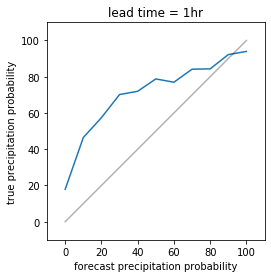

In [89]:
plt.plot(fpop_tpop*100)   # convert to %
plt.plot([0, 50, 100], [0, 50, 100], 'k', alpha=0.3)
plt.title('lead time = 1hr')
plt.xlabel('forecast precipitation probability')
plt.ylabel('true precipitation probability')
plt.xlim([-10, 110])
plt.ylim([-10, 110])
plt.gca().set_aspect('equal', adjustable='box')